# Cepheids: Plots

- Gabriel Wendell Celestino Rocha$^{*, \dagger}$
- João Victor Lacerda Aires
- Leonardo Andrade de Almeida

---

## 0. Setup

In [55]:
import numpy as np
import pandas as pd
from datetime import timedelta
from matplotlib import font_manager
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.collections import PolyCollection, LineCollection

from loguru import logger
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

import numba
import emcee
import corner
from numba import jit, njit


import warnings
warnings.filterwarnings('ignore')

- ### Aesthetic Functions

In [56]:
%matplotlib inline

#######################
##### SINGLE PLOT #####
#######################

cm_font = FontProperties(fname  = 'CutiveMono-Regular.ttf')
gs_font = FontProperties(fname  = 'GillSans-Light.otf')
cm_size = 20

def sm_plot(grid = True, dark_background = False, use_tex = False, font_family = 'monospace', font_size = 15, 
            minorticks = True, major_ticks = True, minor_ticks = True, grid_linestyle = ':', grid_color = '0.50', 
            tick_length_minor = 5, tick_width_minor = 1, tick_length_major = 8, tick_width_major = 1, labelsize = 15):
    """
    Function to improve the aesthetics of Matplotlib graphs.
    """
    if dark_background:
        plt.style.use('dark_background')
    
    if grid:
        plt.grid(True, linestyle = grid_linestyle, color = grid_color, zorder = 0)
    else:
        plt.grid(False)
    
    plt.rcParams['text.usetex'] = use_tex
    plt.rcParams['font.family'] = font_family
    plt.rcParams['font.size'] = font_size
    
    if minorticks:
        plt.minorticks_on()
    else:
        plt.minorticks_off()
    
    if minor_ticks:
        plt.tick_params(axis = 'both', which = 'minor', direction = "in", 
                        top = True, right = True, length = tick_length_minor, 
                        width = tick_width_minor, labelsize = labelsize)
    
    if major_ticks:
        plt.tick_params(axis = 'both', which = 'major', direction = "in", 
                        top = True, right = True, length = tick_length_major, 
                        width = tick_width_major, labelsize = labelsize)
        
        
        
#####################
##### AXES PLOT #####
#####################

def sm_plot_mod(ax, grid = True, dark_background = False, use_tex = False, font = 'monospace', font_size = 15, 
                minor_ticks = True, minor_tick_params = True, major_tick_params = True):
    
    if dark_background:
        plt.style.use('dark_background')
    else:
        plt.style.use('default')

    ax.grid(grid, linestyle = ':', color = '0.50')
    
    plt.rcParams['font.family'] = font
    plt.rcParams['font.size'] = font_size
    
    plt.rcParams['text.usetex'] = use_tex
    
    if minor_ticks:
        ax.minorticks_on()
    else:
        ax.minorticks_off()

    if minor_tick_params:
        ax.tick_params(axis = 'both', which = 'minor', direction = "in", 
                       top = True, right = True, length = 5, width = 1, labelsize = font_size)

    if major_tick_params:
        ax.tick_params(axis = 'both', which = 'major', direction = "in", 
                       top = True, right = True, length = 8, width = 1, labelsize = font_size)
        
        
font_path = 'CutiveMono-Regular.ttf' 
cm_font = font_manager.FontProperties(fname = font_path)

---

### Loading data

In [4]:
data_path = '../data/'
df_path = data_path + 'R11treat.dat'

df = pd.read_csv(df_path, sep = '	', skiprows = 8)
print('DATAFRAME MASTER =D')
display(df)

print('---------------------')
print('  SHAPE =', df.shape)
print('---------------------')

info_path = data_path + 'R11treat_info.txt'

with open(info_path, 'r') as file:
    info = file.read()

print(info)

DATAFRAME MASTER =D


,id,gal,z,dL,M,Merr,m,merr,P,logP,logO_H,bias,Pivot
0,27185,4536,0.006031,25.847143,-7.549763,0.31,24.5123,0.31,13.000,1.113943,-3.46,0.13,1.474125
1,42353,4536,0.006031,25.847143,-6.071363,0.74,25.9907,0.74,13.070,1.116276,-3.03,0.37,1.474125
2,50718,4536,0.006031,25.847143,-7.912863,0.42,24.1492,0.42,13.730,1.137671,-3.36,0.28,1.474125
3,72331,4536,0.006031,25.847143,-7.586963,0.44,24.4751,0.44,13.910,1.143327,-3.19,0.22,1.474125
4,65694,4536,0.006031,25.847143,-7.203863,0.38,24.8582,0.38,14.380,1.157759,-3.10,0.39,1.474125
...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,29163,4258,0.001494,6.402857,-4.879869,0.57,24.1520,0.57,6.739,0.828595,-3.25,0.38,1.474125
642,34729,4258,0.001494,6.402857,-6.371069,0.50,22.6608,0.50,14.920,1.173769,-3.25,0.00,1.474125
643,89375,4258,0.001494,6.402857,-6.619069,0.45,22.4128,0.45,12.380,1.092721,-3.11,0.42,1.474125
644,246695,4258,0.001494,6.402857,-6.434969,0.40,22.5969,0.40,11.200,1.049218,-3.11,0.49,1.474125


---------------------
  SHAPE = (646, 13)
---------------------

# R11treat.dat
#
# This is a processed and treated version of the Cepheid and redshift datas from R11.
# (Riess et al. 2011 [R11], ApJ, 730, 119, Table 2)
#
# Columns:
#      id: the ID of the cepheid
#     gal: the NGC number of the host galaxy
#       z: redshift of the host galaxy
#      dL: the distance computed via Hubble's law
#       M: abs mags M are computed using M = m + 5*log10(dL/Mpc) + 25
#    Merr: abs mags errs are just the mags m errs
#       m: mags m are computed using m = F160W - 0.41*(V_I)
#    merr: mag errs are just those in the F160W mags
#          (errors in V-I were not given in R11)
#       P: period P is in days (errors in the Period were not given)
#    logP: base-10log of the period for each Cepheid
#  logO_H: this is actually log[O/H], not 12 + log[O/H] as in R11
#    bias: this is the crowding bias *already applied* by R11
#
# Notes:
# - cepheid with id 102255 was excluded since its mag err

## 1. Absolute Magnitude vs Period / Metallicity (grouped by galaxies)

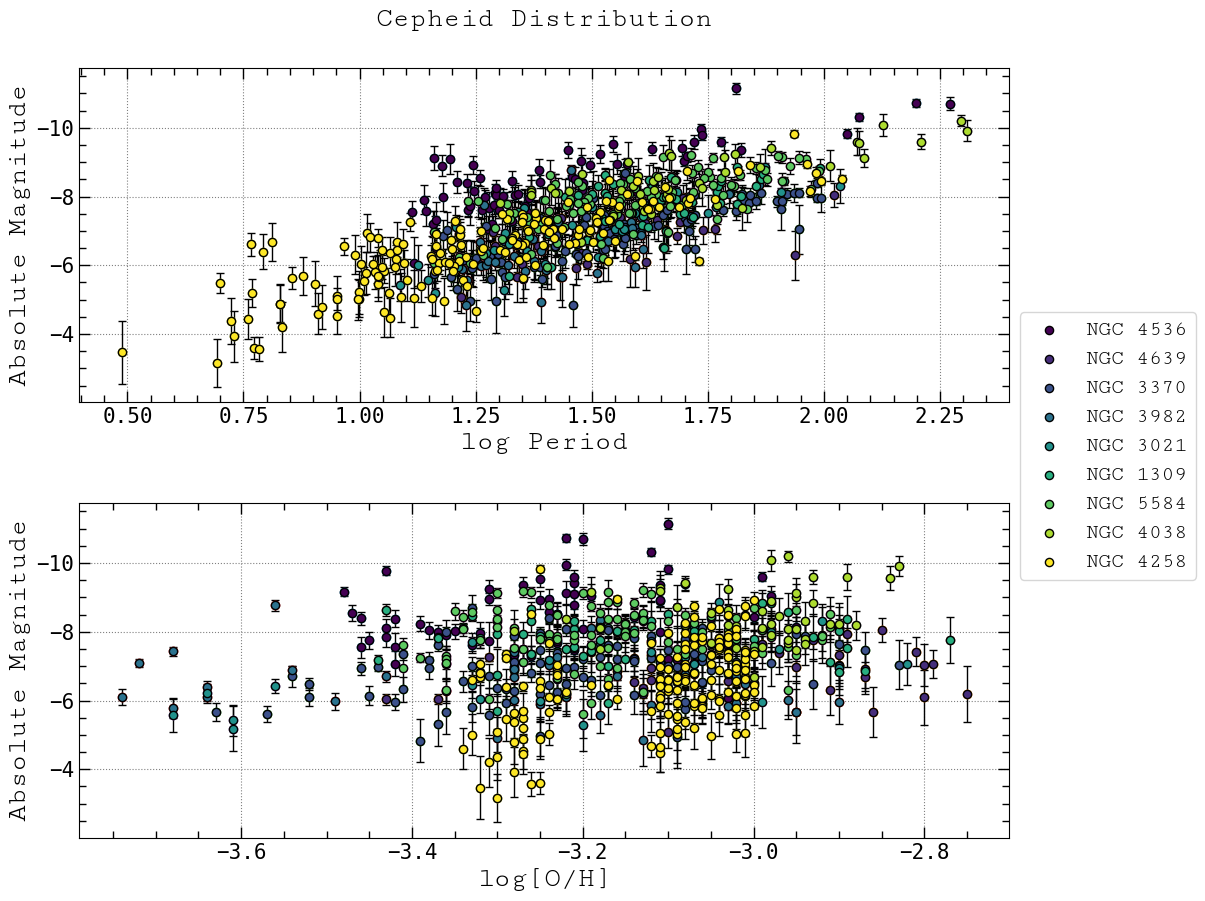

In [74]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 10))

colormap_name = 'viridis'
unique_galaxies = df['gal'].unique()
colors = plt.get_cmap(colormap_name)(np.linspace(0, 1, len(unique_galaxies)))
#colors = plt.cm.tab10(np.linspace(0, 1, len(unique_galaxies)))

for color, gal in zip(colors, unique_galaxies):
    subset = df[df['gal'] == gal]
    ax[0].scatter(
        subset['logP'], subset['M'], color = color, s = 35, edgecolor = 'k', zorder = 3, label = f'NGC {gal}'
    )
    ax[0].errorbar(subset['logP'], subset['M'], yerr = subset['Merr'], fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)

ax[0].set_xlabel(r'log Period', fontproperties = cm_font, fontsize = 20)
ax[0].set_ylabel(r'Absolute Magnitude', fontproperties = cm_font, fontsize = 20)
ax[0].set_title(r'Cepheid Distribution', fontproperties = cm_font, fontsize = 20, pad = 30)

ax[0].invert_yaxis()  
ax[0].legend(loc = 'upper left', bbox_to_anchor = (1, 0.3), prop = cm_font, fontsize = 35)
#plt.tight_layout(rect = [0, 0, 0.85, 1])  

sm_plot_mod(ax[0])

for color, gal in zip(colors, unique_galaxies):
    subset = df[df['gal'] == gal]
    ax[1].scatter(
        subset['logO_H'], subset['M'], color = color, s = 35, edgecolor = 'k', zorder = 3, label = f'NGC {gal}'
    )
    ax[1].errorbar(subset['logO_H'], subset['M'], yerr = subset['Merr'], fmt = 'o', 
                ecolor = 'k', elinewidth = 1, zorder = 2, capsize = 3, lw = 1)
    
fig.subplots_adjust(hspace = 0.3)
    
ax[1].invert_yaxis()      

ax[1].set_ylabel(r'Absolute Magnitude', fontproperties = cm_font, fontsize = 20)
ax[1].set_xlabel(r'log[O/H]', fontproperties = cm_font, fontsize = 20)

sm_plot_mod(ax[1])

plt.savefig('../Plots/Cepheid_Distribution.png', dpi = 400)

## 2. Histograms: Period and Metallicity Distribution (separated by galaxies)

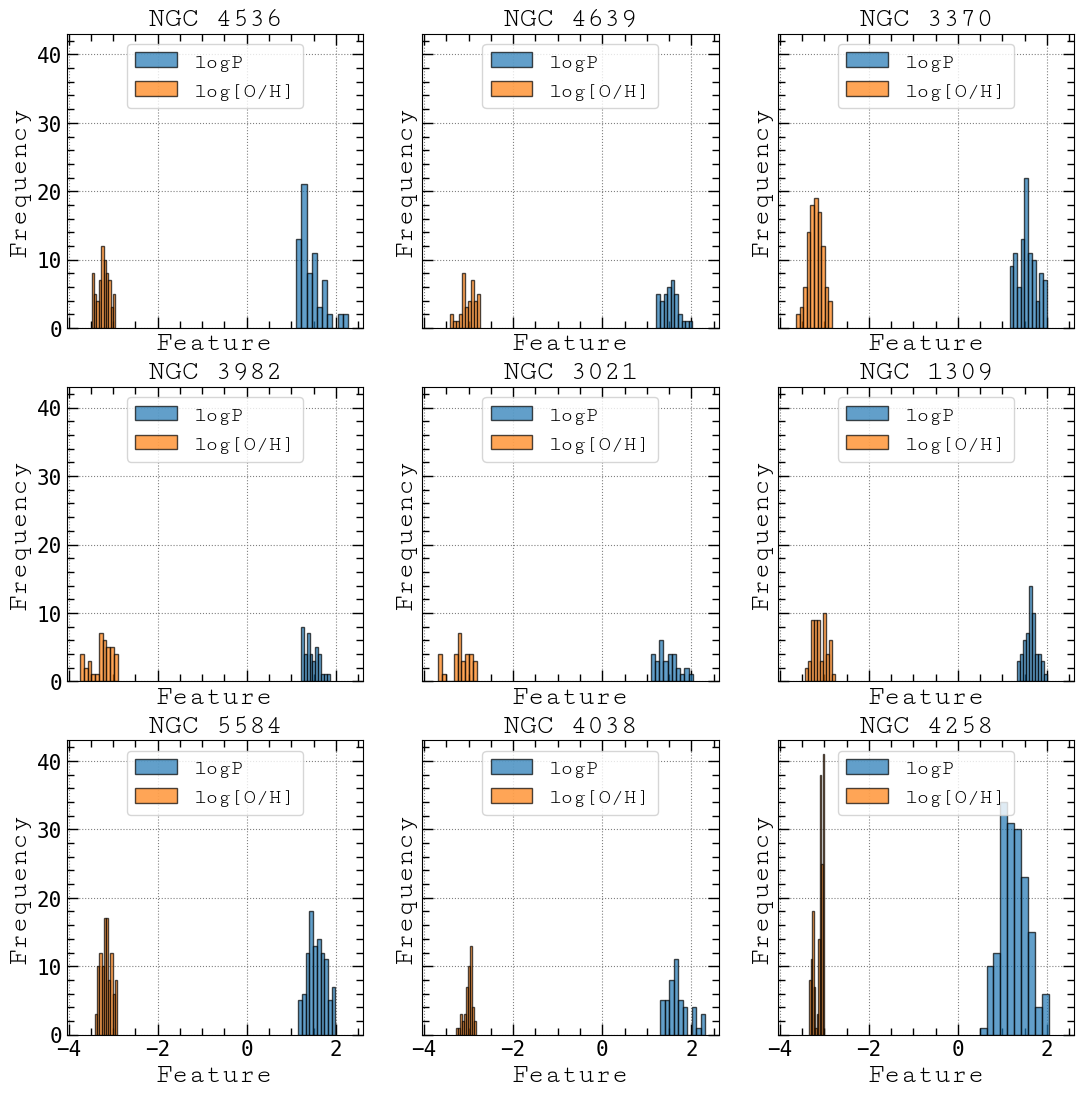

In [81]:
unique_galaxies = df['gal'].unique()

fig, axs = plt.subplots(3, 3, figsize = (13, 13), sharex = True, sharey = True)
axs = axs.flatten()

for ax, gal in zip(axs, unique_galaxies):
    subset = df[df['gal'] == gal]
    ax.hist(subset['logP'], bins = 10, edgecolor = 'k', alpha = 0.7, zorder = 2, label = r'logP')  
    ax.hist(subset['logO_H'], bins = 10, edgecolor = 'k', alpha = 0.7, zorder = 2, label = r'log[O/H]')
    
    ax.set_title(f'NGC {gal}', fontproperties = cm_font, fontsize = 20)
    ax.set_xlabel(r'Feature', fontproperties = cm_font, fontsize = 20)
    ax.set_ylabel(r'Frequency', fontproperties = cm_font, fontsize = 20)
    
    ax.legend(loc = 'upper center', prop = cm_font, fontsize = 20)
    sm_plot_mod(ax)
    
plt.savefig('../Plots/Histograms_individual.png', dpi = 400)

## 3. Histograms: Period and Metallicity Distribution (all together)

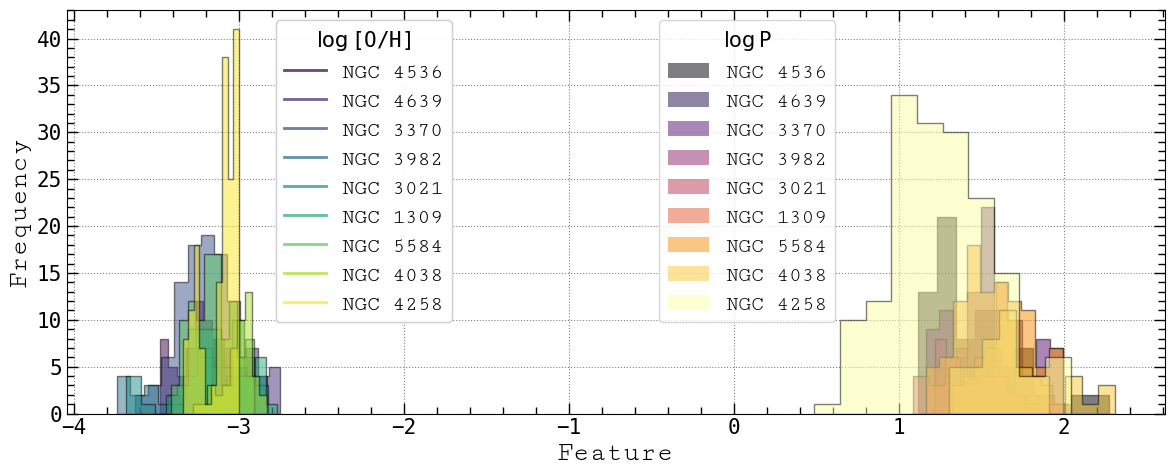

In [139]:
# Set color maps to differentiate galaxies
colormap_logP = 'inferno'
colormap_logO_H = 'viridis'
unique_galaxies = df['gal'].unique()

# Get colors for logP and log[O/H] from chosen colormaps
colors_logP = plt.get_cmap(colormap_logP)(np.linspace(0, 1, len(unique_galaxies)))
colors_logO_H = plt.get_cmap(colormap_logO_H)(np.linspace(0, 1, len(unique_galaxies)))

fig, ax = plt.subplots(figsize = (12, 5))

# Lists to store graphic objects (handles) for the legends
handles_logP = []
handles_logO_H = []

# Loop to plot a histogram for each galaxy
for color_logP, color_logO_H, gal in zip(colors_logP, colors_logO_H, unique_galaxies):
    subset = df[df['gal'] == gal]
    
    # Plotting logP and log[O/H] histograms with different colormaps
    hist_logP = ax.hist(
        subset['logP'], bins = 10, edgecolor = 'k', alpha = 0.5, color = color_logP, 
        label = f'NGC {gal} : logP', zorder = 2, histtype = 'stepfilled'
    )
    hist_logO_H = ax.hist(
        subset['logO_H'], bins = 10, edgecolor = 'k', alpha = 0.5, color = color_logO_H, 
        label = f'NGC {gal} : log[O/H]', zorder = 2, histtype = 'stepfilled'
    )
    
    # Adding the graphic objects to the appropriate list for captions
    handles_logP.append((plt.Rectangle((0, 0), 1, 1, fc = color_logP, alpha = 0.5), f'NGC {gal}'))
    handles_logO_H.append((plt.Line2D([0], [0], color = color_logO_H, lw = 2, alpha = 0.7), f'NGC {gal}'))


ax.set_xlabel(r'Feature', fontproperties = cm_font, fontsize = 20)
ax.set_ylabel(r'Frequency', fontproperties = cm_font, fontsize = 20)

# Creating two caption boxes
legend_logP = ax.legend(handles = [h[0] for h in handles_logP], labels = [h[1] for h in handles_logP], 
                        title = r'$\log$P', loc = 'upper left', bbox_to_anchor = (0.53, 1), prop = cm_font)
legend_logO_H = ax.legend(handles = [h[0] for h in handles_logO_H], labels = [h[1] for h in handles_logO_H], 
                          title = r'$\log$[O/H]', loc = 'upper right', bbox_to_anchor = (0.36, 1), prop = cm_font)

# Adds legends to the chart
ax.add_artist(legend_logP)
ax.add_artist(legend_logO_H)

sm_plot_mod(ax)
plt.tight_layout(rect = [0, 0, 1, 1]) 
plt.savefig('../Plots/Combined_Histograms.png', dpi = 400)